## 1. Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

from gensim.models import Word2Vec

C:\Users\JAVI\Miniconda3\envs\dhds\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 2. Cargar datos

In [2]:
movies=pd.read_csv('../Data/movies.csv')
ratings=pd.read_csv('../Data/ratings.csv')
links=pd.read_csv('../Data/links.csv')
tags=pd.read_csv('../Data/tags.csv')
imdb=pd.read_csv('../Data/tab_imdb_info.csv',index_col=0)

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
links.dtypes

movieId      int64
imdbId       int64
tmdbId     float64
dtype: object

In [6]:
imdb.head()

,actors,country,director,req_imdbid,year
0,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney",USA,John Lasseter,tt0114709,1995
1,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",USA,Joe Johnston,tt0113497,1995
2,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",USA,Howard Deutch,tt0113228,1995
3,"Whitney Houston, Angela Bassett, Loretta Devin...",USA,Forest Whitaker,tt0114885,1995
4,"Steve Martin, Diane Keaton, Martin Short, Kimb...",USA,Charles Shyer,tt0113041,1995


In [7]:
imdb.head()

,actors,country,director,req_imdbid,year
0,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney",USA,John Lasseter,tt0114709,1995
1,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",USA,Joe Johnston,tt0113497,1995
2,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",USA,Howard Deutch,tt0113228,1995
3,"Whitney Houston, Angela Bassett, Loretta Devin...",USA,Forest Whitaker,tt0114885,1995
4,"Steve Martin, Diane Keaton, Martin Short, Kimb...",USA,Charles Shyer,tt0113041,1995


## 3. Feature Extraction

Corregir id's de imdb:

In [8]:
imdb['imdbId']=imdb['req_imdbid'].apply(lambda x: x[2:]).astype('int64')

In [9]:
pd.merge(links,movies,on='movieId').head()

,movieId,imdbId,tmdbId,title,genres
0,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,113497,8844.0,Jumanji (1995),Adventure|Children|Fantasy
2,3,113228,15602.0,Grumpier Old Men (1995),Comedy|Romance
3,4,114885,31357.0,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,113041,11862.0,Father of the Bride Part II (1995),Comedy


In [10]:
imdb.isna().sum()

actors        32
country       12
director      94
req_imdbid     0
year           0
imdbId         0
dtype: int64

In [11]:
imdb.fillna('-',inplace=True)

In [12]:
imdb['actors'].apply(lambda x: len(x.split(','))).unique()

array([4, 2, 3, 1], dtype=int64)

In [13]:
# imdb['director1'] = imdb['director'].apply(lambda x: x.split(',')[0])
# imdb['actor1'] = imdb['actors'].apply(lambda x: x.split(',')[0])
# #imdb['actor2'] = imdb['actors'].apply(lambda x: x.split(',')[1])
# imdb['country1'] = imdb['country'].apply(lambda x: x.split(',')[0])

Creo un dataframe con todos los datos necesarios para crear features por películas:

In [14]:
mov_with_feat = pd.merge(links,imdb,on='imdbId')
mov_with_feat = pd.merge(mov_with_feat,movies,on='movieId')
mov_with_feat.head()

,movieId,imdbId,tmdbId,actors,country,director,req_imdbid,year,title,genres
0,1,114709,862.0,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney",USA,John Lasseter,tt0114709,1995,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,113497,8844.0,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",USA,Joe Johnston,tt0113497,1995,Jumanji (1995),Adventure|Children|Fantasy
2,3,113228,15602.0,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",USA,Howard Deutch,tt0113228,1995,Grumpier Old Men (1995),Comedy|Romance
3,4,114885,31357.0,"Whitney Houston, Angela Bassett, Loretta Devin...",USA,Forest Whitaker,tt0114885,1995,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,113041,11862.0,"Steve Martin, Diane Keaton, Martin Short, Kimb...",USA,Charles Shyer,tt0113041,1995,Father of the Bride Part II (1995),Comedy


In [15]:
mov_with_feat.isna().sum()

movieId       0
imdbId        0
tmdbId        8
actors        0
country       0
director      0
req_imdbid    0
year          0
title         0
genres        0
dtype: int64

In [16]:
mov_with_feat.fillna('-',inplace=True)

In [17]:
mov_with_feat['actors'] = mov_with_feat['actors'].str.replace(' ','')
mov_with_feat['genres'] = mov_with_feat['genres'].str.replace('|',',')
mov_with_feat['genres'] = mov_with_feat['genres'].str.replace(' ','')
mov_with_feat['director'] = mov_with_feat['director'].str.replace(' ','')
mov_with_feat['country'] = mov_with_feat['country'].str.replace(' ','')
mov_with_feat.head()

,movieId,imdbId,tmdbId,actors,country,director,req_imdbid,year,title,genres
0,1,114709,862,"TomHanks,TimAllen,DonRickles,JimVarney",USA,JohnLasseter,tt0114709,1995,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy"
1,2,113497,8844,"RobinWilliams,JonathanHyde,KirstenDunst,Bradle...",USA,JoeJohnston,tt0113497,1995,Jumanji (1995),"Adventure,Children,Fantasy"
2,3,113228,15602,"WalterMatthau,JackLemmon,SophiaLoren,Ann-Margret",USA,HowardDeutch,tt0113228,1995,Grumpier Old Men (1995),"Comedy,Romance"
3,4,114885,31357,"WhitneyHouston,AngelaBassett,LorettaDevine,Lel...",USA,ForestWhitaker,tt0114885,1995,Waiting to Exhale (1995),"Comedy,Drama,Romance"
4,5,113041,11862,"SteveMartin,DianeKeaton,MartinShort,KimberlyWi...",USA,CharlesShyer,tt0113041,1995,Father of the Bride Part II (1995),Comedy


Armado de tokens:

In [18]:
#df1 = mov_with_feat[['actor1','director1','country1']]
df1 = mov_with_feat[['actors','director','country','genres']]
df1 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1)
df1 = df1.str.replace(' ','')
df1 = pd.DataFrame({'clean': df1}) 
print(df1.iloc[0].values)
sent = [row.split(',') for row in df1['clean']]
mov_sent = [a for a in zip(imdb['req_imdbid'],sent)]
mov_sent[0:2]

['TomHanks,TimAllen,DonRickles,JimVarney,JohnLasseter,USA,Adventure,Animation,Children,Comedy,Fantasy']


[('tt0114709',
  ['TomHanks',
   'TimAllen',
   'DonRickles',
   'JimVarney',
   'JohnLasseter',
   'USA',
   'Adventure',
   'Animation',
   'Children',
   'Comedy',
   'Fantasy']),
 ('tt0113497',
  ['RobinWilliams',
   'JonathanHyde',
   'KirstenDunst',
   'BradleyPierce',
   'JoeJohnston',
   'USA',
   'Adventure',
   'Children',
   'Fantasy'])]

Entrenar modelo de word2vec de gensim:

In [19]:
model = Word2Vec(sent, min_count=1,size= 50,workers=3, window =3, sg = 1)

In [20]:
#Representation for director John Lasseter
model.wv['JohnLasseter']

array([-0.06902692, -0.02032053,  0.03269949,  0.03699073, -0.01038133,
       -0.098679  , -0.04925255, -0.02807162,  0.07255221, -0.05724383,
       -0.02070779, -0.0142433 ,  0.01451093,  0.00126002,  0.03355167,
        0.00326157,  0.02814179, -0.0115273 ,  0.0567862 ,  0.06987983,
       -0.02888509, -0.09200695,  0.06987879, -0.13282795,  0.02872403,
       -0.01149121,  0.06413184,  0.01549263, -0.07157039,  0.00485235,
       -0.00513043,  0.0225374 , -0.09410509,  0.1012375 , -0.07112029,
        0.05992955, -0.01250696, -0.01380466, -0.06387655, -0.03802859,
       -0.00252734, -0.07385489,  0.02803891, -0.06623362, -0.08583655,
       -0.00519474,  0.03062098, -0.01952633, -0.02446698,  0.03779869],
      dtype=float32)

In [21]:
#Get similarity
model.wv.similarity('TomHanks', 'USA')

0.49676630721162374

In [22]:
model.wv['Adventure']

array([-0.36064607, -0.6015488 , -0.12491114, -0.09620138,  0.20001468,
       -1.0764909 , -0.0052591 , -0.07640246, -0.17127128, -0.28454098,
       -0.05811675, -0.03585466,  0.24743639,  0.19692487,  0.42435157,
        0.2864549 ,  0.5383293 , -0.29927072,  0.33277774,  0.57374096,
       -0.0390864 , -0.39783266,  0.46668407, -0.8412741 ,  0.59209794,
       -0.7145393 ,  0.35548297, -0.18797548, -0.7981928 , -0.49112025,
        0.15210055, -0.12869711, -0.7132978 ,  0.451838  , -0.5172065 ,
        0.41149077, -0.5992487 , -0.19612435,  0.17891514,  0.12907426,
        0.5669889 , -0.39235252, -0.47345188,  0.24119934,  0.3819955 ,
        0.277306  , -0.30181584,  0.05197136, -0.00199552,  0.44454426],
      dtype=float32)

In [23]:
model.wv['(nogenreslisted)']

array([-0.07402472, -0.05072477,  0.1107582 ,  0.09212188, -0.06972072,
       -0.18893251, -0.11675443, -0.02925096,  0.14427005, -0.11924504,
       -0.08035097,  0.00849434,  0.00372628,  0.00710055,  0.07307328,
       -0.03694683,  0.06470872,  0.02072913,  0.08899808,  0.13610278,
       -0.06060383, -0.15395327,  0.10914179, -0.23890573,  0.06124378,
       -0.03961135,  0.12101928,  0.07490422, -0.11642683,  0.00536723,
       -0.00501172,  0.07674105, -0.17773826,  0.2313854 , -0.13351521,
        0.10425684, -0.04216936, -0.02507067, -0.10544158, -0.06557231,
       -0.00192441, -0.14310166,  0.02266148, -0.16865273, -0.16870368,
       -0.0077989 ,  0.05181112, -0.03525853, -0.05211582,  0.06562388],
      dtype=float32)

In [24]:
model.wv.most_similar('Romance')

[('UK', 0.9894570112228394),
 ('War', 0.981853723526001),
 ('Australia', 0.9812292456626892),
 ('Canada', 0.980694055557251),
 ('USA', 0.9797766804695129),
 ('-', 0.9791041016578674),
 ('Germany', 0.9749627113342285),
 ('Comedy', 0.9730315208435059),
 ('Western', 0.9723223447799683),
 ('France', 0.9693043828010559)]

In [25]:
imdb.head()

,actors,country,director,req_imdbid,year,imdbId
0,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney",USA,John Lasseter,tt0114709,1995,114709
1,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",USA,Joe Johnston,tt0113497,1995,113497
2,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",USA,Howard Deutch,tt0113228,1995,113228
3,"Whitney Houston, Angela Bassett, Loretta Devin...",USA,Forest Whitaker,tt0114885,1995,114885
4,"Steve Martin, Diane Keaton, Martin Short, Kimb...",USA,Charles Shyer,tt0113041,1995,113041


In [26]:
imdb.dtypes

actors        object
country       object
director      object
req_imdbid    object
year          object
imdbId         int64
dtype: object

In [27]:
def rep_col(text):
    #print(text)
    rep = []
    for item in text.split(','):
        rep.append(model.wv[item])
    return np.concatenate(rep,axis=0)

In [28]:
def items_rep(item_lst):
    a=0
    for item in item_lst:
        a+=model.wv[item]
    a/=len(item_lst)
    return a



In [29]:
mov_with_feat['actors_rep'] = mov_with_feat['actors'].apply(lambda x:x.split(',')).apply(items_rep)
mov_with_feat['director_rep'] = mov_with_feat['director'].apply(lambda x:x.split(',')).apply(items_rep)
mov_with_feat['country_rep'] = mov_with_feat['country'].apply(lambda x:x.split(',')).apply(items_rep)
mov_with_feat['genres_rep'] = mov_with_feat['genres'].apply(lambda x:x.split(',')).apply(items_rep)
mov_with_feat.head()

,movieId,imdbId,tmdbId,actors,country,director,req_imdbid,year,title,genres,actors_rep,director_rep,country_rep,genres_rep
0,1,114709,862,"TomHanks,TimAllen,DonRickles,JimVarney",USA,JohnLasseter,tt0114709,1995,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","[-0.0960319, -0.022097396, 0.09610726, 0.09217...","[-0.06902692, -0.020320531, 0.03269949, 0.0369...","[-0.5291597, -0.6734069, -0.2821772, -0.167874...","[-0.28821427, -0.5480379, -0.13412249, -0.1192..."
1,2,113497,8844,"RobinWilliams,JonathanHyde,KirstenDunst,Bradle...",USA,JoeJohnston,tt0113497,1995,Jumanji (1995),"Adventure,Children,Fantasy","[-0.07841623, -0.015286557, 0.07697222, 0.0712...","[-0.05384186, -0.038962144, 0.046443004, 0.046...","[-0.5291597, -0.6734069, -0.2821772, -0.167874...","[-0.32954922, -0.49126133, -0.14008866, -0.172..."
2,3,113228,15602,"WalterMatthau,JackLemmon,SophiaLoren,Ann-Margret",USA,HowardDeutch,tt0113228,1995,Grumpier Old Men (1995),"Comedy,Romance","[-0.10424325, -0.025989171, 0.101216875, 0.096...","[-0.05840567, -0.016608005, 0.047147427, 0.036...","[-0.5291597, -0.6734069, -0.2821772, -0.167874...","[-0.10806366, -0.5624227, -0.07015285, 0.05349..."
3,4,114885,31357,"WhitneyHouston,AngelaBassett,LorettaDevine,Lel...",USA,ForestWhitaker,tt0114885,1995,Waiting to Exhale (1995),"Comedy,Drama,Romance","[-0.06734513, -0.010235792, 0.06708083, 0.0585...","[-0.098534904, -0.044069916, 0.103668995, 0.10...","[-0.5291597, -0.6734069, -0.2821772, -0.167874...","[-0.03677793, -0.6061794, -0.025810288, 0.0835..."
4,5,113041,11862,"SteveMartin,DianeKeaton,MartinShort,KimberlyWi...",USA,CharlesShyer,tt0113041,1995,Father of the Bride Part II (1995),Comedy,"[-0.10269821, -0.024273984, 0.10728241, 0.0948...","[-0.03272634, -0.02133254, 0.03425686, 0.03177...","[-0.5291597, -0.6734069, -0.2821772, -0.167874...","[-0.08054416, -0.7197027, -0.07439148, 0.08736..."


In [30]:
# mov_with_feat['actors_rep'][0]

In [31]:
# mov_with_feat['director_rep'][0]

In [32]:
# mov_with_feat['country_rep'][0]

In [33]:
# np.concatenate([mov_with_feat['actors_rep'][0],mov_with_feat['director_rep'][0],mov_with_feat['country_rep'][0]],axis=0)

In [34]:
mov_with_feat['all_feat']=mov_with_feat.apply(lambda x: np.concatenate([x['actors_rep'],x['director_rep'],x['country_rep'],x['genres_rep']],axis=0),axis=1)

In [35]:
mov_with_feat[['movieId','all_feat']].head()

,movieId,all_feat
0,1,"[-0.0960319, -0.022097396, 0.09610726, 0.09217..."
1,2,"[-0.07841623, -0.015286557, 0.07697222, 0.0712..."
2,3,"[-0.10424325, -0.025989171, 0.101216875, 0.096..."
3,4,"[-0.06734513, -0.010235792, 0.06708083, 0.0585..."
4,5,"[-0.10269821, -0.024273984, 0.10728241, 0.0948..."


In [36]:
a = mov_with_feat['all_feat'][0].reshape(1,-1)
for mov_feat in mov_with_feat['all_feat'][1:]:
    b = mov_feat.reshape(1,-1)
    a = np.concatenate([a,b])

a.shape

(9742, 200)

In [37]:
feature_matrix = a
feature_matrix.shape

(9742, 200)

In [38]:
feat_names = ['f'+str(i+1) for i in range(feature_matrix.shape[1])]

In [39]:
feature_matrix = pd.DataFrame(feature_matrix,index=mov_with_feat['movieId'],columns=feat_names)

In [40]:
feature_matrix.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200
movieId,,,,,,,,,,,,,,,,,,,,,
1,-0.096032,-0.022097,0.096107,0.092173,-0.069829,-0.172570,-0.100821,-0.033339,0.158643,-0.111983,...,0.543185,-0.383237,-0.393627,0.181510,0.306281,0.230766,-0.272134,0.043170,0.028098,0.430541
2,-0.078416,-0.015287,0.076972,0.071211,-0.056282,-0.134641,-0.088162,-0.029439,0.133179,-0.091126,...,0.493018,-0.362867,-0.378356,0.250063,0.316867,0.226561,-0.215054,0.086625,0.026813,0.373165
3,-0.104243,-0.025989,0.101217,0.096202,-0.072755,-0.177771,-0.111414,-0.035495,0.171938,-0.117676,...,0.472847,-0.404220,-0.513982,-0.030722,0.288811,0.169149,-0.332474,0.009879,0.123505,0.458085
4,-0.067345,-0.010236,0.067081,0.058548,-0.040621,-0.111843,-0.076015,-0.021089,0.110564,-0.076084,...,0.515236,-0.442002,-0.553784,-0.090330,0.314931,0.187779,-0.368472,-0.016916,0.106105,0.485244
5,-0.102698,-0.024274,0.107282,0.094831,-0.070647,-0.179384,-0.116284,-0.036751,0.174914,-0.126336,...,0.616811,-0.471956,-0.567767,-0.050624,0.324780,0.263123,-0.469047,0.006225,0.032699,0.575492


In [41]:
feature_matrix.shape

(9742, 200)

## 4. Perfiles de Usuarios

Los mismos se obtienen de multiplicar la matriz user-item (n_users\*n_items) con la matriz de movie_features (n_items\*n_features)

In [42]:
ratings_matrix = ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating')
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
ratings_matrix.shape

(610, 9724)

In [44]:
# np.dot(ratings_matrix.values,feature_matrix.values)

In [45]:
len(ratings['movieId'].unique())

9724

In [46]:
len(movies['movieId'].unique())

9742

In [47]:
not_rated = []
for iid in movies['movieId'].unique():
    if iid not in ratings['movieId'].unique():
        not_rated.append(iid)
not_rated

[1076,
 2939,
 3338,
 3456,
 4194,
 5721,
 6668,
 6849,
 7020,
 7792,
 8765,
 25855,
 26085,
 30892,
 32160,
 32371,
 34482,
 85565]

In [48]:
len(not_rated)

18

Hay 18 películas que no tienen puntaje de ningun usuario. Por lo tanto, las sacaremos del dataset para este enfoque, ya que necesitamos los rating de los usuarios para las peliculas.

In [49]:
feature_matrix = feature_matrix.drop(index=not_rated)
feature_matrix.shape

(9724, 200)

In [50]:
user_profiles = np.dot(ratings_matrix.values,feature_matrix.values)

In [51]:
user_profiles = pd.DataFrame(user_profiles,index=ratings_matrix.index,columns=feature_matrix.columns)

In [52]:
user_profiles.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200
userId,,,,,,,,,,,,,,,,,,,,,
1,-73.162169,-20.051171,74.411525,68.919746,-50.707436,-134.949778,-82.390759,-24.944229,123.058566,-87.072532,...,519.710142,-410.932990,-462.908655,20.072104,323.494853,212.224987,-324.106973,20.312185,45.018878,440.894026
2,-10.207872,-2.806102,10.285926,9.551610,-6.922418,-18.727052,-11.435347,-3.319213,17.043928,-12.090920,...,57.721504,-48.228306,-55.862623,-9.911879,34.630671,23.088252,-40.326699,-0.762175,4.765308,51.225499
3,-5.928212,-2.468640,5.299010,4.847624,-3.694456,-11.562600,-6.055904,-1.701043,8.732749,-7.011068,...,49.321859,-38.063122,-41.133277,3.266037,31.873703,21.368657,-29.844344,2.075258,1.529976,39.514304
4,-50.210739,-13.589964,51.556469,47.527020,-35.359998,-91.993718,-56.623434,-16.862973,84.788851,-60.043778,...,395.712451,-328.106872,-387.114376,-50.937525,240.878721,153.366755,-274.037342,-3.172486,49.491830,355.623164
5,-11.503054,-3.159008,11.672788,10.927287,-8.171681,-21.506874,-12.918545,-3.978558,19.477767,-13.760499,...,80.251779,-66.522736,-77.260171,-5.675408,50.312281,31.302525,-52.299560,0.805199,9.884950,70.185026


In [53]:
user_profiles.shape

(610, 200)

### Lista de películas vistas por usuario

In [54]:
ratings_sorted = ratings.sort_values(by='timestamp')
movies_by_user = pd.DataFrame(ratings_sorted.groupby('userId')['movieId'].apply(list))
movies_by_user.head()

,movieId
userId,
1,"[804, 1210, 2628, 2826, 2018, 3578, 3617, 3744..."
2,"[318, 79132, 131724, 115713, 99114, 112552, 35..."
3,"[1275, 2105, 1371, 914, 1263, 2080, 31, 720, 3..."
4,"[171, 902, 2351, 417, 1304, 2959, 2712, 162, 5..."
5,"[590, 592, 150, 380, 296, 457, 588, 153, 344, ..."


## 5. Recomendaciones por usuario

In [55]:
def get_user_recommendations(uid,num):
    C = cosine_similarity(np.atleast_2d(user_profiles.loc[uid]), feature_matrix.values)
    R = np.argsort(C)[:, ::-1]
    recommendations = [i for i in R[0] if i not in movies_by_user.loc[uid].values]
    return movies['title'][recommendations].head(num)

In [56]:
get_user_recommendations(uid=1,num=10)

4717                                 Teen Wolf (1985)
5407    Andalusian Dog, An (Chien andalou, Un) (1929)
1827                              Faculty, The (1998)
6077                       Memoirs of a Geisha (2005)
7724                                  Puncture (2011)
1215                                  In & Out (1997)
6123    Tristram Shandy: A Cock and Bull Story (2005)
4487                         Man's Best Friend (1993)
777               20,000 Leagues Under the Sea (1954)
5422                         Wuthering Heights (1939)
Name: title, dtype: object

In [57]:
get_user_recommendations(uid=154,num=10)

7615                                 Roommate, The (2011)
422                               Last Action Hero (1993)
4650                                Big Empty, The (2003)
4416                                     Babe, The (1992)
8457    Internet's Own Boy: The Story of Aaron Swartz,...
8677                       The Diary of Anne Frank (2009)
7609                             Midnight in Paris (2011)
897                 Cheech and Chong's Up in Smoke (1978)
4421                               What's Up, Doc? (1972)
6471                                     Lucky You (2007)
Name: title, dtype: object

In [58]:
get_user_recommendations(uid=610,num=10)

3921                          24 Hour Party People (2002)
8219                                         Turbo (2013)
6441                        I Think I Love My Wife (2007)
8040               Fantastic Fear of Everything, A (2012)
6341                                  Good Year, A (2006)
5233    Happenstance (Battement d'ailes du papillon, L...
4495                       Atragon (Kaitei Gunkan) (1963)
7543                                     Hall Pass (2011)
5555                               Nuns on the Run (1990)
5794                                         Hitch (2005)
Name: title, dtype: object

In [89]:
get_user_recommendations(uid=120,num=10)

6077                           Memoirs of a Geisha (2005)
7290                                  Little Ashes (2008)
7823                             Atomic Brain, The (1963)
2173                               Mystery, Alaska (1999)
1827                                  Faculty, The (1998)
9337                                   Indignation (2016)
3455                                Altered States (1980)
4717                                     Teen Wolf (1985)
3907    Nosferatu the Vampyre (Nosferatu: Phantom der ...
6123        Tristram Shandy: A Cock and Bull Story (2005)
Name: title, dtype: object

In [90]:
get_user_recommendations(uid=230,num=10)

6077                           Memoirs of a Geisha (2005)
4717                                     Teen Wolf (1985)
3880                        Look Who's Talking Now (1993)
1827                                  Faculty, The (1998)
1215                                      In & Out (1997)
3167                                      Scarface (1983)
1804                                     Rambo III (1988)
6663    In the Name of the King: A Dungeon Siege Tale ...
3409                             Jurassic Park III (2001)
5407        Andalusian Dog, An (Chien andalou, Un) (1929)
Name: title, dtype: object

## 6. Train Test Split

In [59]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(ratings, test_size=0.25, random_state=42,
                                               shuffle=True,stratify=ratings['userId'])

In [60]:
ratings['userId'].value_counts(ascending=True).head()

442    20
431    20
569    20
595    20
406    20
Name: userId, dtype: int64

In [61]:
ratings_train['userId'].value_counts(ascending=True).head()

147    15
569    15
194    15
406    15
278    15
Name: userId, dtype: int64

In [62]:
ratings_test['userId'].value_counts(ascending=True).head()

406    5
37     5
147    5
53     5
569    5
Name: userId, dtype: int64

In [63]:
# ratings_train.to_csv('../Data/ratings_train.csv')

In [64]:
# ratings_test.to_csv('../Data/ratings_test.csv')

In [65]:
ratings_matrix = ratings_train.pivot_table(index=['userId'],columns=['movieId'],values='rating')
ratings_matrix = ratings_matrix.fillna(0)
for mid in movies['movieId'].unique():
    if mid not in ratings_matrix.columns and mid not in not_rated:
        ratings_matrix[mid] = 0.0
ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,185435,186587,188797,189713,190183,190215,190219,190221,193567,193579
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
ratings_matrix = ratings_matrix.sort_index(axis=1)
ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
feature_matrix.shape

(9724, 200)

In [68]:
user_profiles = np.dot(ratings_matrix.values,feature_matrix.values)
user_profiles = pd.DataFrame(user_profiles,index=ratings_matrix.index,columns=feature_matrix.columns)
user_profiles.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200
userId,,,,,,,,,,,,,,,,,,,,,
1,-55.499473,-15.232576,56.440271,52.138050,-38.472092,-102.145811,-62.362068,-18.973473,93.172311,-65.983555,...,390.661277,-307.626612,-345.168288,19.673197,243.288676,159.993039,-242.099785,16.314769,32.600870,330.090920
2,-7.673988,-2.033372,7.770275,7.153398,-5.234415,-14.056490,-8.544466,-2.517871,12.848649,-9.062382,...,43.961603,-37.028860,-42.974966,-8.319987,26.174670,17.596943,-30.770090,-0.860131,3.750826,39.209255
3,-4.072432,-1.169049,4.028119,3.687239,-2.755781,-7.332495,-4.398231,-1.292029,6.621311,-4.796881,...,31.933763,-24.606013,-26.568467,2.242180,20.421815,13.735056,-19.246596,1.304576,1.244947,25.759976
4,-37.844672,-10.344227,38.890441,35.849960,-26.678248,-69.597746,-42.812167,-12.732752,63.742373,-45.222134,...,295.796121,-245.540630,-290.444956,-41.880070,178.997858,114.720201,-207.213778,-3.279897,36.249939,267.046397
5,-9.104350,-2.518753,9.171480,8.615066,-6.454783,-17.024886,-10.162874,-3.105300,15.257165,-10.847573,...,60.971855,-50.576910,-58.612953,-4.307239,38.435116,23.955445,-39.858475,0.946303,7.175312,53.213288


In [69]:
user_profiles.shape

(610, 200)

### Lista de películas vistas por usuario

In [70]:
ratings_sorted = ratings.sort_values(by='timestamp')
movies_by_user = pd.DataFrame(ratings_sorted.groupby('userId')['movieId'].apply(list))
movies_by_user.head()

,movieId
userId,
1,"[804, 1210, 2628, 2826, 2018, 3578, 3617, 3744..."
2,"[318, 79132, 131724, 115713, 99114, 112552, 35..."
3,"[1275, 2105, 1371, 914, 1263, 2080, 31, 720, 3..."
4,"[171, 902, 2351, 417, 1304, 2959, 2712, 162, 5..."
5,"[590, 592, 150, 380, 296, 457, 588, 153, 344, ..."


## 5. Recomendaciones por usuario

In [71]:
def get_user_recommendations(uid,num):
    C = cosine_similarity(np.atleast_2d(user_profiles.loc[uid]), feature_matrix.values)
    R = np.argsort(C)[:, ::-1]
    recommendations = [i for i in R[0] if i not in movies_by_user.loc[uid].values]
    return movies['title'][recommendations[0:num]]#.head(num)

In [72]:
get_user_recommendations(uid=1,num=10)

4717                                 Teen Wolf (1985)
1827                              Faculty, The (1998)
5407    Andalusian Dog, An (Chien andalou, Un) (1929)
7724                                  Puncture (2011)
777               20,000 Leagues Under the Sea (1954)
6077                       Memoirs of a Geisha (2005)
4487                         Man's Best Friend (1993)
1215                                  In & Out (1997)
6123    Tristram Shandy: A Cock and Bull Story (2005)
5422                         Wuthering Heights (1939)
Name: title, dtype: object

In [73]:
get_user_recommendations(uid=154,num=10)

7615                     Roommate, The (2011)
4650                    Big Empty, The (2003)
4421                   What's Up, Doc? (1972)
6471                         Lucky You (2007)
4416                         Babe, The (1992)
897     Cheech and Chong's Up in Smoke (1978)
422                   Last Action Hero (1993)
549                        Dragonheart (1996)
2832                   Pawnbroker, The (1964)
8677           The Diary of Anne Frank (2009)
Name: title, dtype: object

In [74]:
get_user_recommendations(uid=320,num=10)

5555                               Nuns on the Run (1990)
8911    Ghost in the Shell: Stand Alone Complex - The ...
901                                         Brazil (1985)
2869                                   Phantasm II (1988)
7308    Emperor's New Groove 2: Kronk's New Groove, Th...
2325                                Mansfield Park (1999)
4090                                       Ragtime (1981)
5790                                        El Cid (1961)
3426                                     Skin Deep (1989)
8327                                    Wrong Cops (2013)
Name: title, dtype: object

In [75]:
get_user_recommendations(uid=610,num=10)

3921                          24 Hour Party People (2002)
6441                        I Think I Love My Wife (2007)
8219                                         Turbo (2013)
7543                                     Hall Pass (2011)
8040               Fantastic Fear of Everything, A (2012)
5233    Happenstance (Battement d'ailes du papillon, L...
5555                               Nuns on the Run (1990)
5794                                         Hitch (2005)
6341                                  Good Year, A (2006)
4495                       Atragon (Kaitei Gunkan) (1963)
Name: title, dtype: object

In [76]:
u610_rec = get_user_recommendations(uid=610,num=10)
ratings_test.loc[ratings_test['userId']==610]
u610_rec.values

array(['24 Hour Party People (2002)', 'I Think I Love My Wife (2007)',
       'Turbo (2013)', 'Hall Pass (2011)',
       'Fantastic Fear of Everything, A (2012)',
       "Happenstance (Battement d'ailes du papillon, Le) (2001)",
       'Nuns on the Run (1990)', 'Hitch (2005)', 'Good Year, A (2006)',
       'Atragon (Kaitei Gunkan) (1963)'], dtype=object)

In [77]:
a = pd.DataFrame(movies.iloc[u610_rec.index]['movieId'])
u610_rec = pd.DataFrame(u610_rec)
u610_rec = pd.concat([a,u610_rec],axis=1)
u610_rec

,movieId,title
3921,5508,24 Hour Party People (2002)
6441,51903,I Think I Love My Wife (2007)
8219,103755,Turbo (2013)
7543,85022,Hall Pass (2011)
8040,98279,"Fantastic Fear of Everything, A (2012)"
5233,8575,"Happenstance (Battement d'ailes du papillon, L..."
5555,26700,Nuns on the Run (1990)
5794,31685,Hitch (2005)
6341,49130,"Good Year, A (2006)"
4495,6654,Atragon (Kaitei Gunkan) (1963)


In [78]:
a = u610_rec['movieId']
b = ratings_test.loc[ratings_test['userId']==610,'movieId']
np.intersect1d(a,b)

array([], dtype=int64)

In [79]:
# a=[1,2,3]
# b=[1,2,5,6,7,8]
# np.intersect1d(a,b)

In [80]:
# tp = 0
# fp = 0
# for item in a:
#     if item in b:
#         tp+=1
# fp = 10 - tp
# print(tp,fp)

In [81]:
# a = [1,2,3]
# b = [1,4,5,7,685,2]
# # tp = 0
# # fp = 0
# # for item in a:
# #     if item in b:
# #         tp+=1
# # fp = 10 - tp
# # print(tp,fp)

# def intersection(lst1, lst2): 
#     return list(set(lst1) & set(lst2)) 
# intersection(a,b)

In [82]:
feature_matrix.index

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', name='movieId', length=9724)

In [83]:
# def intersection(lst1, lst2): 
#     return list(set(lst1) & set(lst2)) 

# all_tp = 0
# all_fp = 0
# for uid in ratings['userId'].unique():
#     if uid%100==0:
#         print(uid)
#     user_rec = pd.DataFrame(get_user_recommendations(uid=uid,num=10))
#     user_rec = pd.concat([pd.DataFrame(movies.iloc[user_rec.index]['movieId']),user_rec],axis=1)
#     recommended_movies = user_rec['movieId']
#     watched_movies = ratings_test.loc[ratings_test['userId']==610,'movieId']
#     #tp = len(np.intersect1d(recommended_movies,watched_movies))
#     #fp = 10 - tp
#     all_tp += len(np.intersect1d(recommended_movies,watched_movies))
#     #all_tp+=tp
#     #all_fp+=fp
# all_fp=len(ratings['userId'].unique())*10-all_tp
# print(all_tp,all_fp)

In [84]:
# precision=all_tp/(all_tp+all_fp)
# print(precision)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CE40F39828>]],
      dtype=object)

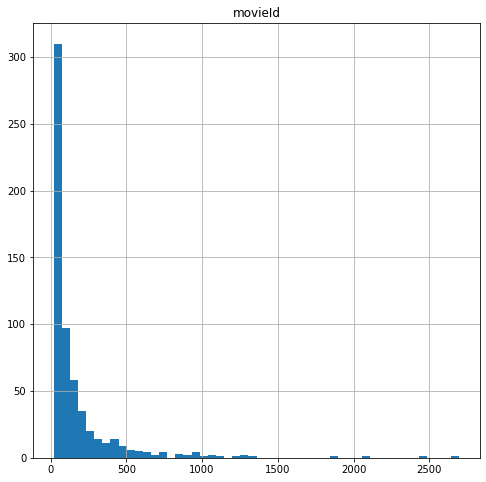

In [85]:
ratings[['movieId','userId']].groupby('userId').count().hist(bins=50,figsize=(8,8))

In [86]:
a = ratings[['movieId','userId']].groupby('userId').count()

In [87]:
a['movieId']

userId
1       232
2        29
3        39
4       216
5        44
6       314
7       152
8        47
9        46
10      140
11       64
12       32
13       31
14       48
15      135
16       98
17      105
18      502
19      703
20      242
21      443
22      119
23      121
24      110
25       26
26       21
27      135
28      570
29       81
30       34
       ... 
581      40
582      56
583      56
584      83
585      61
586     208
587     165
588      56
589      40
590     728
591      54
592      94
593     103
594     232
595      20
596     411
597     443
598      21
599    2478
600     763
601     101
602     135
603     943
604     100
605     221
606    1115
607     187
608     831
609      37
610    1302
Name: movieId, Length: 610, dtype: int64

In [88]:
import plotly
#import plotly.plotly as py
import chart_studio.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, plot

init_notebook_mode(connected=True)

trace = go.Histogram(x=a['movieId'],
                    xbins=dict(start=0,end=2700,size=20),)

layout = go.Layout(title='Distribución de Cant. películas miradas',
                   titlefont = dict(size = 20),
                   paper_bgcolor =  'rgba(0,0,0,0)',
                   plot_bgcolor = 'rgba(0,0,0,0)',
                   bargap=0.1,
                   bargroupgap=0.2
                   )
fig = dict(data=[trace],layout=layout)
figure=go.Figure(data=[trace],layout=layout)
plotly.offline.iplot(figure)